# POTTS MODEL

#### $$H = -J\sum_{\langle i,j \rangle} \delta_{s_i,s_j}$$


$$
\{s_i \in 1, 2, ..., q\}
$$

In [204]:
import numpy as np
import matplotlib.pyplot as plt

In [250]:
class Potts:
    """Class for simulating a Potts model and Wang-Landau method for DOS."""

    def __init__(self, T, L, q, J=1):
        self.T = T        # Temperature
        self.L = L        # Linear size of lattice
        self.q = q+1       # Number of states
        # self.lattice = np.random.randint(1, self.q, (self.L, self.L))  # Random initial state
        self.lattice = np.ones((self.L, self.L))
        self.E = self.energy(self.lattice)  # Initial energy
        self.J = J

    def energy(self, lattice):
        """Compute the energy of the lattice."""
        E = 0
        for i in range(self.L):
            for j in range(self.L):
                s0 = self.lattice[i, j]
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    x = (i + dx) % self.L
                    y = (j + dy) % self.L
                    s1 = self.lattice[x, y]
                    E -= 1 if s1 == s0 else 0
        return (E/2.)
    
    def energy_limits(self, L, J):
        """Compute the energy limits of the lattice."""
        print(f"E_min: {-J*2*L**2} \t E_max: 0")
        return -J*2*self.L**2, 0



    # def mcmc(self, N_sweeps):
    #     """Metropolis Monte Carlo moves"""
    #     self.metropolis(N_sweeps)

    def deltaE(self, x, y, s0):
        dE = 0
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            x1 = (x + dx) % self.L
            y1 = (y + dy) % self.L
            s1 = self.s[x1, y1]
            print(f"s0: {s0} \t s1: {s1}",)

            dE -= 1 if s1 == s0 else 0
        
        return dE
        
    def isFlat(self, hist, f):
        """Check if the histogram is flat."""
        values = list(hist.values())
        if np.min(values) > 0.8*np.mean(values) and np.max(values) < 1.2*np.mean(values):
            return True
        else:
            return False
    
    def WangLandau(self, N_sweeps):
        """Wang-Landau algorithm to estimate the density of states."""
        print("Wang-Landau")
        print(f"Lattice:\n{self.lattice}")
        
        # Initialize the density of states and histogram
        E_min, E_max = self.energy_limits(self.L, self.J)
        energy_bins = np.linspace(E_min, E_max, -E_min+1)

        g = {E: 1.0 for E in energy_bins}
        hist = {E: 0 for E in energy_bins}

        f = np.e

        for ii in range(N_sweeps):
                current_energy = self.energy(self.lattice)
                # choose a site at random and propose a new state
                x, y = np.random.randint(0, self.L), np.random.randint(0, self.L)
                s0 = self.lattice[x, y]
                s1 = np.random.randint(1, self.q)
                
                self.lattice[x, y] = s1
                new_energy = self.energy(self.lattice)

                if (np.random.rand() < min(1, g[int(current_energy)]/g[int(new_energy)])):
                    g[int(new_energy)] *= f
                    hist[int(new_energy)] += 1
                else:
                    self.lattice[x, y] = s0
                    g[int(current_energy)] *= f
                    hist[int(current_energy)] += 1
                # plt.plot(energy_bins, list(hist.values()))
                # plt.show()
                isFlat = self.isFlat(hist, f)
                if isFlat:
                    f = np.sqrt(f)
                    hist = {E: 0 for E in energy_bins}
                    print(f"Flat histogram at sweep {ii}")
                    break  
        
        print(f"Max sweeps reached")
        return self.lattice, g, hist
    
    def plot(self, g, hist):
        """Plot the density of states and histogram."""
        energy_bins = np.linspace(*self.energy_limits(self.L, self.J), self.N_bins)
        plt.plot(energy_bins, g, label="Density of states")
        plt.plot(energy_bins, hist, label="Histogram")
        plt.legend()
        plt.show()



Wang-Landau
Lattice:
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
E_min: -32 	 E_max: 0
Max sweeps reached


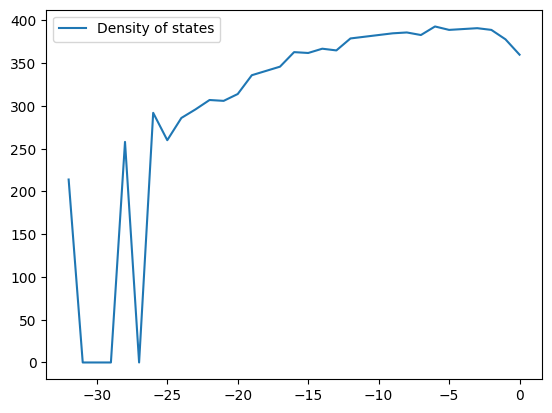

In [275]:
P = Potts(T=1, L=4, q=8)
lattice, g, hist = P.WangLandau(10000)

g_x = list(g.keys())
g_y = list(g.values())

hist_x = list(hist.keys())
hist_y = list(hist.values())

plt.plot(g_x, np.log(g_y), label="Density of states")
# plt.plot(hist_x, hist_y, label="Histogram")
plt.legend()
plt.show()


In [279]:
#!/usr/bin/env python
"""
  Wang-Landau algorithm for 2D Ising model
  Jueyuan Xiao, Aug.6, 2021, using python 3.6
"""

import matplotlib.pyplot as plt
import numpy as np
import math
import time

MCsweeps = 1000  # Total MC sweeps
L = 100            # 2D Ising model lattice = L x L
flatness = 0.8      # “flat histogram”: histogram H(E) for all possible E is not less than 80% of the average histogram
N = L * L           # 2D Ising model lattice = L x L

def calEnergy(lattice):
    # Energy of a 2D Ising lattice
    E_N = 0
    for i in range(L):
        for j in range(L):
            S = lattice[i, j]
            WF = lattice[(i+1) % L, j] + lattice[i, (j+1) % L] + lattice[(i-1) % L, j] + lattice[i, (j-1) % L]
            E_N += -WF * S  # Each neighbor gives environment energy
    return int(E_N / 2.)  # Counted twice

def thermod(T, lngE, Energies, E0):
    # Thermodynamics using DOS, T: Temperature
    Z = 0   # Z = sum of g(E) * exp(-beta*E)
    E_T = 0 # = U(T) = (sum of E * g(E) * exp(-beta*E)) / (sum of g(E) * exp(-beta*E))
    E2_T = 0
    kB = 1
    for i, E in enumerate(Energies):
        try:
            w = float(math.exp(lngE[i] - lngE[0] - (E + E0) / T))
        except OverflowError:
            w = float('inf')
        Z += w
        E_T += w * E
        E2_T += w * E ** 2
    E_T *= 1. / Z
    C_T = (E2_T / Z - E_T ** 2) / T ** 2    # the DoS is calculation of the specific heat
    F_T = -kB * T * math.log(Z)
    #P_ET = math.pow(w, 1 / (kB * T))
    #print(P_ET, ", ", E_T/N)
    S_T = (E_T - F_T) / T
    return (F_T / N, C_T / N, E_T / N, S_T)

def WangLandau(MCsweeps, L, N, indE, E0, flatness):
    # Ising lattice at infinite temperature, Generates a random 2D Ising lattice
    latt = np.random.randint(-1, 0, size=(L, L))
    latt[latt == 0] = 1
    # Corresponding energy
    Ene = calEnergy(latt)
    lngE = np.zeros(len(Energies), dtype=float)  # Logarithm of the density of states log(g(E))
    Hist = np.zeros(len(Energies), dtype=float)  # Histogram
    lnf = 1.0   # g(E) -> g(E)*f, or equivalently, lngE[i] -> lngE[i] + lnf. f0=e

    for itt in range(MCsweeps):
        n = int(np.random.rand() * N)           # The site to flip
        (i, j) = (int(n % L), int(n / L))       # The coordinates of the site
        S = latt[i, j]                          # its spin
        WF = latt[(i + 1) % L, j] + latt[i, (j + 1) % L] + latt[(i - 1) % L, j] + latt[i, (j - 1) % L]
        Enew = Ene + 2 * S * WF                 # The energy of the tried step

        #P = exp(lngE[indE[Ene + E0]] - lngE[indE[Enew + E0]])  # Probability to accept according to Wang-Landau
        lnP = lngE[indE[Ene + E0]] - lngE[indE[Enew + E0]]
        if lnP > math.log((np.random.rand())):  # Metropolis condition, use log for easy cal
            latt[i, j] = -S  # step is accepted, update lattice
            Ene = Enew  # accept the new energy

        Hist[indE[Ene + E0]] += 1.  # Histogram is update at each Monte Carlo step!
        lngE[indE[Ene + E0]] += lnf  # Density of states is also modified at each step!

        if itt % 100 == 0:
            aH = sum(Hist) / (N + 0.0)  # mean Histogram
            mH = min(Hist)  # minimum of the Histogram
            print("f = ", math.exp(lnf))
            if mH > aH * flatness:  # min(Histogram) >= average(Histogram)*flatness as "flat"
                # Normalize the histogram
                # Hist *= len(Hist)/float(sum(Hist))
                lgC = lngE - lngE[0]
                plt.plot(Energies, lgC, '-o', label='log(g(E))')
                plt.plot(Energies, Hist, '-s', label='Histogram')
                plt.xlabel('Energy')
                plt.legend(loc='best')
                print(itt, 'steps , min H =', mH, ',  average H =', aH, ',  f =', math.exp(lnf))
                plt.show()
                Hist = np.zeros(len(Hist))  # Resetting histogram
                lnf /= 2.  # and reducing the modification factor
    return (lngE, Hist)

time_start = time.time()
# Possible energies of the Ising model
Energies = (4 * np.arange(N + 1) - 2 * N).tolist()
Energies.pop(1)  # Note that energies Emin+4 and Emax-4
Energies.pop(-2)  # Remove impossible value

# Maximum energy
E0 = Energies[-1]
# Index array which will give us position in the Histogram array from knowing the Energy
indE = -np.ones(E0 * 2 + 1, dtype=int)
for i, E in enumerate(Energies): indE[E + E0] = i

(lngE, Hist) = WangLandau(MCsweeps, L, N, indE, E0, flatness)

# Normalize the density of states, knowing that the lowest energy state is double degenerate
# lgC = log( (exp(lngE[0])+exp(lngE[-1]))/4. )
if lngE[-1] < lngE[0]:
    lgC = lngE[0] + math.log(1 + math.exp(lngE[-1] - lngE[0])) - math.log(4.)
else:
    lgC = lngE[-1] + math.log(1 + math.exp(lngE[0] - lngE[-1])) - math.log(4.)
lngE -= lgC
for i in range(len(lngE)):
    if lngE[i] < 0: lngE[i] = 0
# Normalize the histogram
Hist *= len(Hist) / float(sum(Hist))

Te = np.linspace(0.4, 8., 600)  # T varies from 0.4 to 8
Thm = []
for T in Te:
    Thm.append(thermod(T, lngE, Energies, E0))
Thm = np.array(Thm)
time_end = time.time()
print('Time cost', time_end - time_start, 's')

# plt.plot(Energies, np.exp(lngE), '-', label='log(g(E))')
# # plt.plot(Energies, Hist, '-', label='Histogram')
# plt.xlabel('Energy')
# plt.legend(loc='best')
# plt.show()
# fig = plt.figure(1)
# ax1 = plt.subplot(2, 1, 1)
# plt.plot(Te, Thm[:, 0], label='F(T)/N')
# plt.xlabel('T')
# plt.legend(loc='best')
# ax2 = plt.subplot(2, 1, 2)
# plt.plot(Te, Thm[:, 1], label='C(T)/N')
# plt.xlabel('T')
# plt.legend(loc='best')
# plt.show()
# plt.plot(Te, Thm[:, 3], '-s', label='S(T)')
# plt.xlabel('T')
# plt.legend(loc='best')
# plt.show()

f =  2.718281828459045
f =  2.718281828459045
f =  2.718281828459045
f =  2.718281828459045
f =  2.718281828459045
f =  2.718281828459045
f =  2.718281828459045
f =  2.718281828459045
f =  2.718281828459045
f =  2.718281828459045
Time cost 3.028456926345825 s
